# Interactive Notebook - Host Classification Pipeline

In this project, we implemented a machine learning pipeline for host classification only based on the sequences of virusgenomes. Each step in the pipeline was handeled like one module, where bigger functions were outsourced. In the end we are doing a short discussion of our choices and results. The pipeline will consist of these main steps:

### 1. Preprocessing
Here we tried to extract the most valueable (and still handable) information out of the virus genomes.
- Feature extraction out of all genomes (and storage of features in csv files)
- Encoding of the features (It is necessary for the Elkanoto classifier to work on 0/1-Labels)
- Representation of features in a directionary (key: hostID of virusgenome, value: features of virusgenome)

### 2. Data Exploration
Our goal was to identify any potential issues with the data such as class imbalance and outliers.
- Investigation of the raw dataset structure (Number of fasta/fna Files per Host, Duplicates)
- Visualization of the distribution of features and labels (t-SNE feature reduction (based of different feature combinations))

### 3. Classification
In this phase, we builded and trained classification models to predict the host type.
- Choosing of classification algorithms (We tried SVM, DecisionTree, kNeightbor and Elkanoto PU Classification)
- Splitting of the data into training and test sets (We used Cross Validation with 4 folds)
- Fine-tuning of the model using techniques such as cross-validation and hyperparameter tuning (e.g. our Elkanoto hold out ratio)

### 4. Evaluation
After training the models, we evaluated the performance based on their Cross-Validation Statistics. This includes:
- Measuring performance metrics (We measured balanced Accuracy, Precision, Recall, Specifity and F1-score)
- Comparing the performance of different models

### 5. Query Prediction
After evaluating the performance, we want to use the valueable models (We use balanced accuracy and F1 > 0.7) for query prediction.

# Conclusion
In the end of this project, it seemed that we were able to build a good classifier for one host (hamster with ID 10036), because of data issues (inbalance and not seperatebality of virusgenomes for many classes) and computing power (We could not used storage and computation intensive features like kMers for k > 10). But we archived to build a robust classification pipeline that can be easy reused and extended to classify other hosts based on different features.

In [1]:
# LOAD LIBRARIES


# General libs
import os
import numpy as np
import pandas as pd
from Bio import SeqIO

# Math and plotting libs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Machine lerarning libs
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, make_scorer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Own functions
from classification.ElkanotoSVCClassifier import ElkanotoSVCClassifier
from dataPreprocessing import DataPreprocessing
from dataPreparation import DataPreparation


In [4]:
# GLOBAL PARAMETERS

# Define chosen features (and optional reduction of them) and activation of preprocessing and chosen model
featureSets = [{ "kmer_simple": [3, 6]}, { "kmer_simple": [3] }, { "kmer_simple": [6] }, { "kmer": [3, 6] }, { "kmer": [2, 3, 6] }]
doPreprocessing = True # whether to generate the files for those feature sets
usedModel = "svm"
reduceFeatureDimensionality = False

# Define data to use (hostIDs that are selected as training data and for which a classifier should be builded)
hostsToIncludeInTrainingData = [9031, 9455, 9534, 9544, 9823, 9913, 10036, 10090, 1644094]
hostsToBuildClassifierFor = [10036]
featureFileToUse = "features_kmer-3-6.csv" 
queryFeatureSet = { "kmer": [3, 6] } # Features for the training must also be used for the queries

# Define important paths
featureFileFolder = "../features"
featureFilePrefix = "features"
genomeParentFolder = "../viral_genomes"
queryParentFolder = "../queryFiles"

# fix randomness
randomState = 42

## 1. Data Preprocessing

In [5]:
# Preprocessing means regenerating the feature files for the chosen feature sets
if doPreprocessing:
    # get all hosts
    allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
    filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/" + host) if f.is_file()] for host in allHosts}

    # filter out files that exist in multiple hosts
    nonUnique = set()
    for host in allHosts:
        for otherHost in allHosts:
            if host != otherHost:
                appearInBoth = set(filesForHosts[host]).intersection(set(filesForHosts[otherHost]))
                nonUnique = nonUnique.union(appearInBoth)
    for host in allHosts:
        filesForHosts[host] = [f for f in filesForHosts[host] if f not in nonUnique]

    # create feature files
    for featureSet in featureSets:
        # feature file suffix
        suffix = ""
        for k, v in featureSet.items():
            suffix += f"_{k}"
            for val in v:
                suffix += f"-{val}"
        print("Creating feature set " + suffix)

        # extract features
        with open(f"{featureFileFolder}/{featureFilePrefix}{suffix}.csv", "w") as featureFile:
            dataPreprocessor = DataPreprocessing.DataPreprocessing()
            for host in allHosts:
                print ("Extracting features for host: " + host)
                for genomeFilename in filesForHosts[host]:
                    with open(f"{genomeParentFolder}/{host}/{genomeFilename}", "r") as genomeFile:
                        # get sequence
                        lines = genomeFile.readlines()
                        sequence = "".join(lines[1:]).replace("\n", "")
                        # flatten feature dict to list
                        features = [x for v in dataPreprocessor.extractFeaturesFromGenome(sequence, featureSet).values() for x in v]
                        # write as csv
                        featureFile.write(host + "," + genomeFilename.split(".")[0] + "," + ",".join(map(str, features)) + "\n")


# Create dictionary of hosts (as key) and lists (of feature lists for each virus) (as value)
featuresPerHost = {}
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = []

# Load features of virus sequences for each host in seperate list and convert them to a np array
print("Loading Data...")
with open(f"{featureFileFolder}/{featureFileToUse}") as featureFile:
    for line in featureFile:
        # split csv
        values = line.rstrip().split(",")
        # get host
        host = int(values[0])
        if host in hostsToIncludeInTrainingData:
            # if host should be loaded, save features for this virus
            featuresPerHost[host].append(list(map(float, values[2:])))

print("Storing Data...")
for host in hostsToIncludeInTrainingData:
    featuresPerHost[host] = np.array(featuresPerHost[host])
print("Finished.")

Creating feature set _kmer_simple-3-6
Extracting features for host: 9455
Extracting features for host: 9031
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 9544
Extracting features for host: 9913
Extracting features for host: 9534
Extracting features for host: 1644094
Extracting features for host: 9823
Creating feature set _kmer_simple-3
Extracting features for host: 9455
Extracting features for host: 9031
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 9544
Extracting features for host: 9913
Extracting features for host: 9534
Extracting features for host: 1644094
Extracting features for host: 9823
Creating feature set _kmer_simple-6
Extracting features for host: 9455
Extracting features for host: 9031
Extracting features for host: 10036
Extracting features for host: 10090
Extracting features for host: 9544
Extracting features for host: 9913
Extracting features for host: 9534
Ext

## 2. Data Exploration

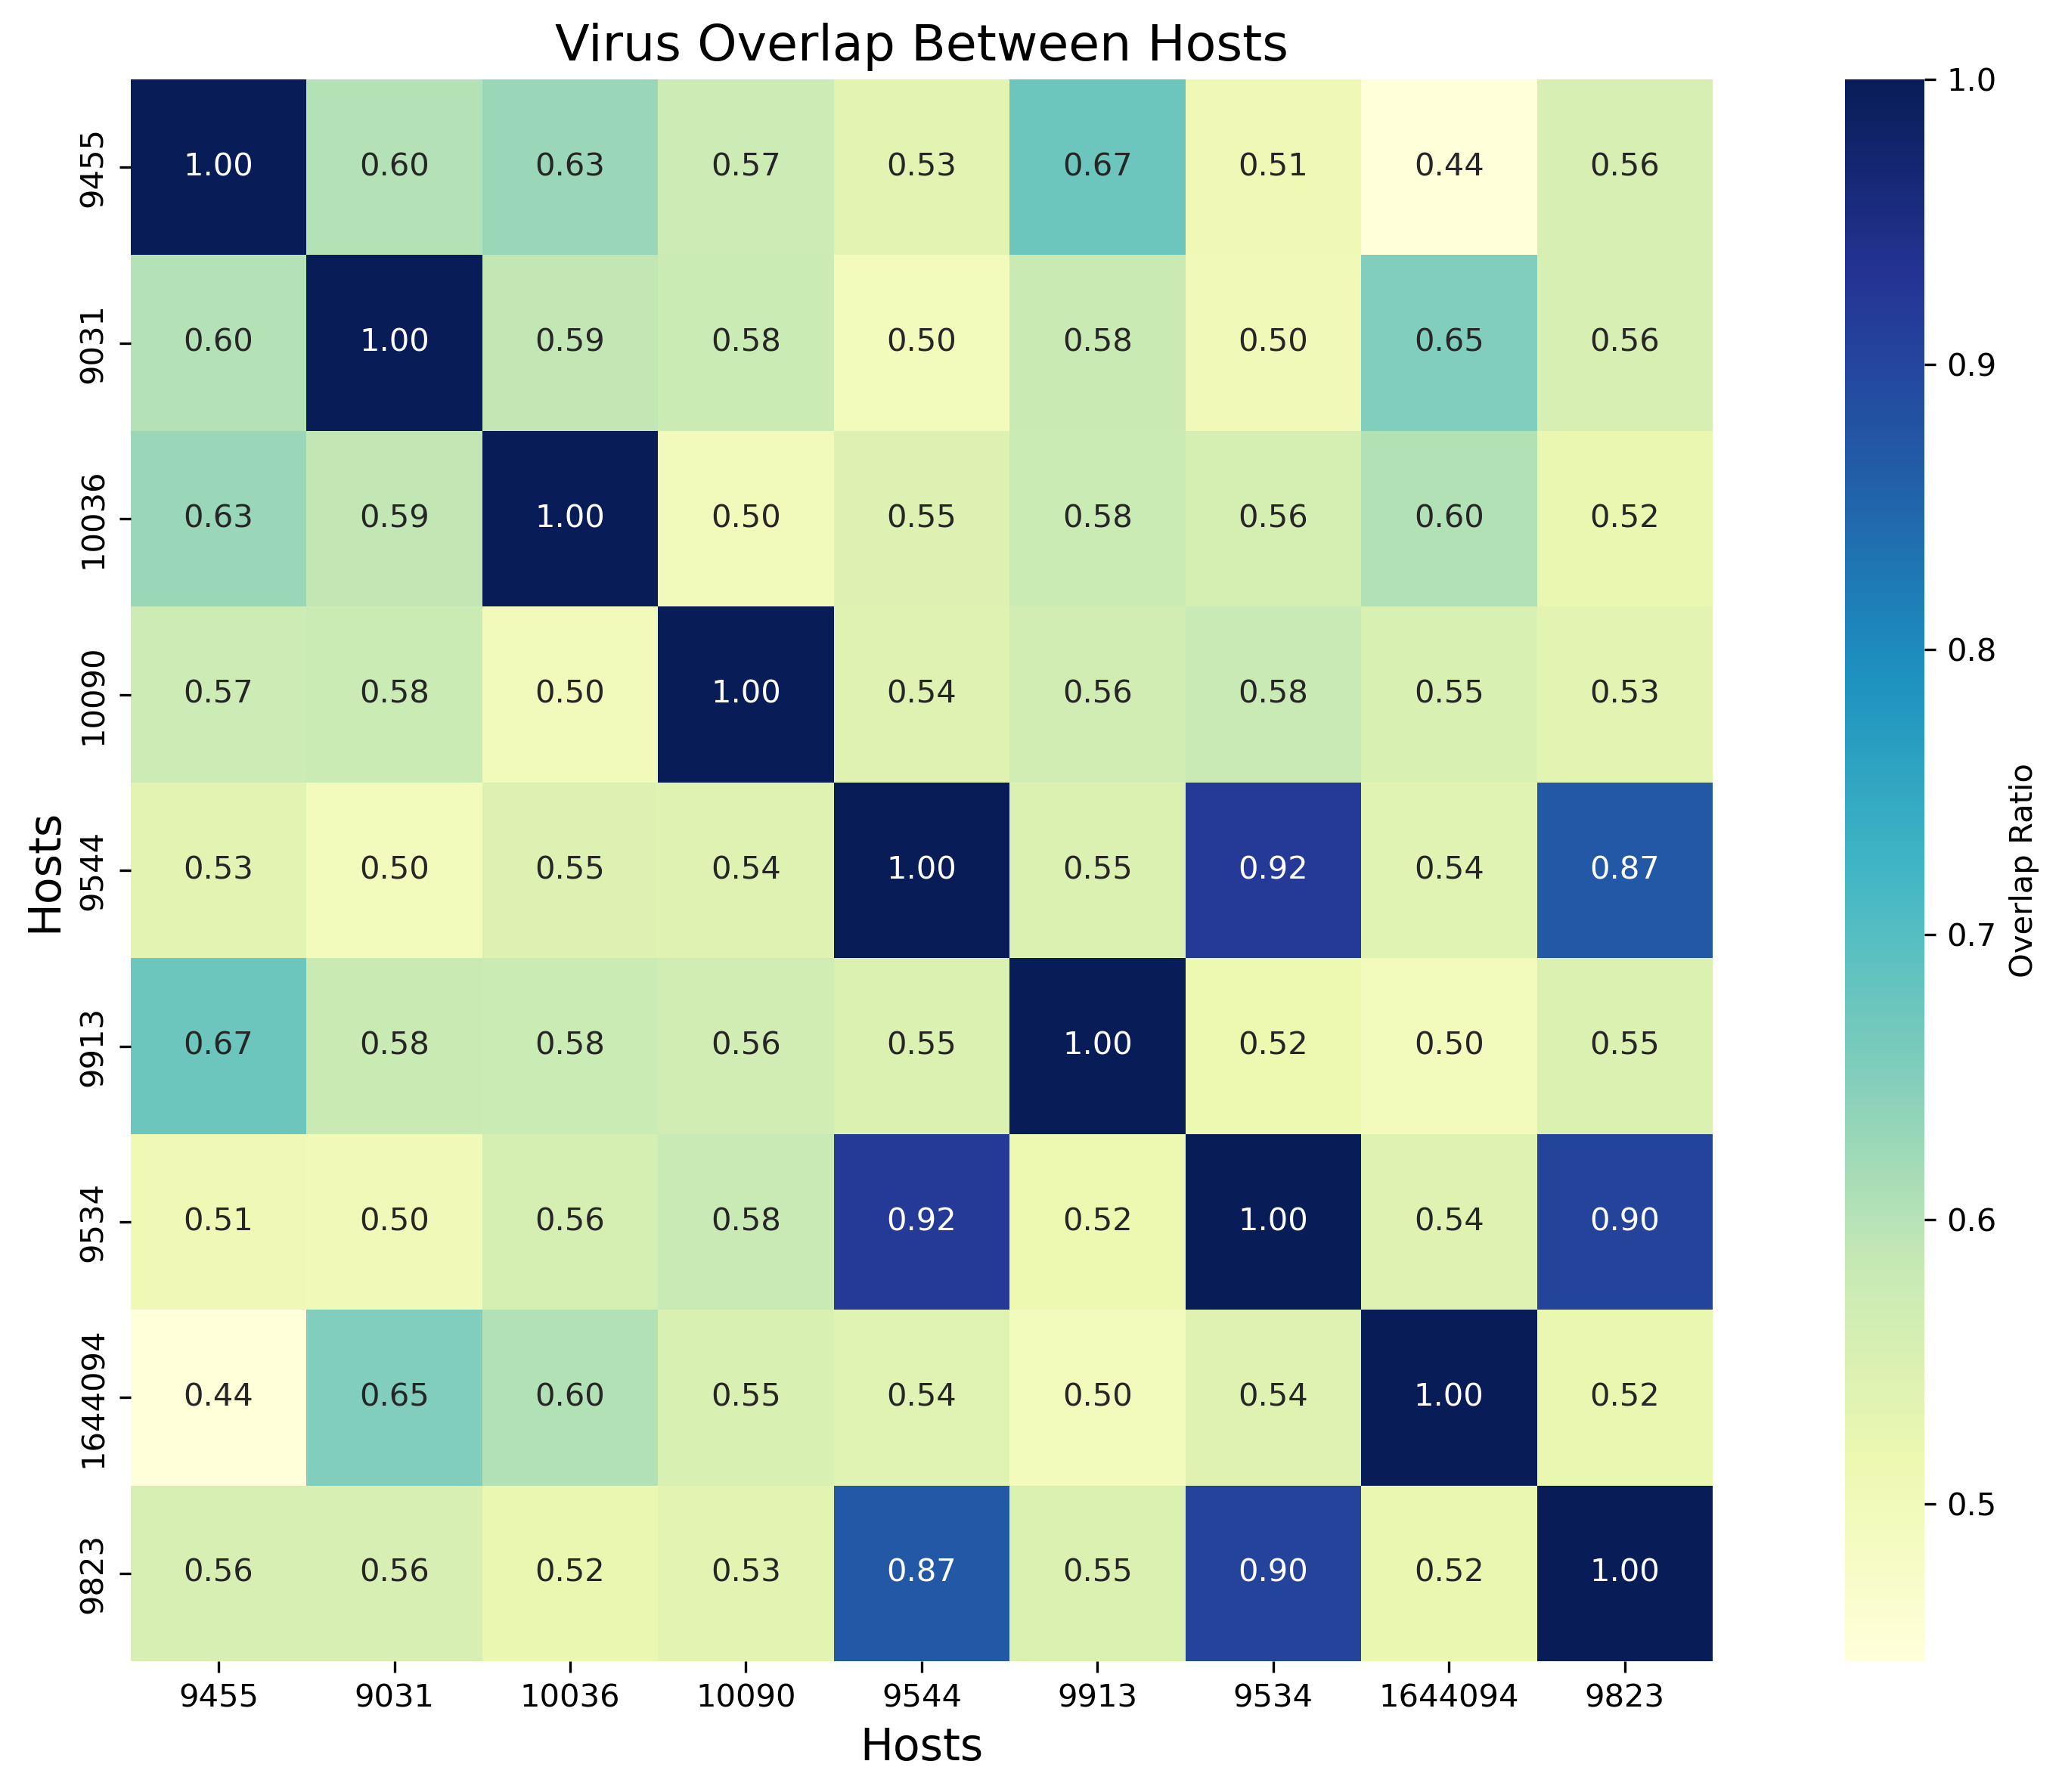

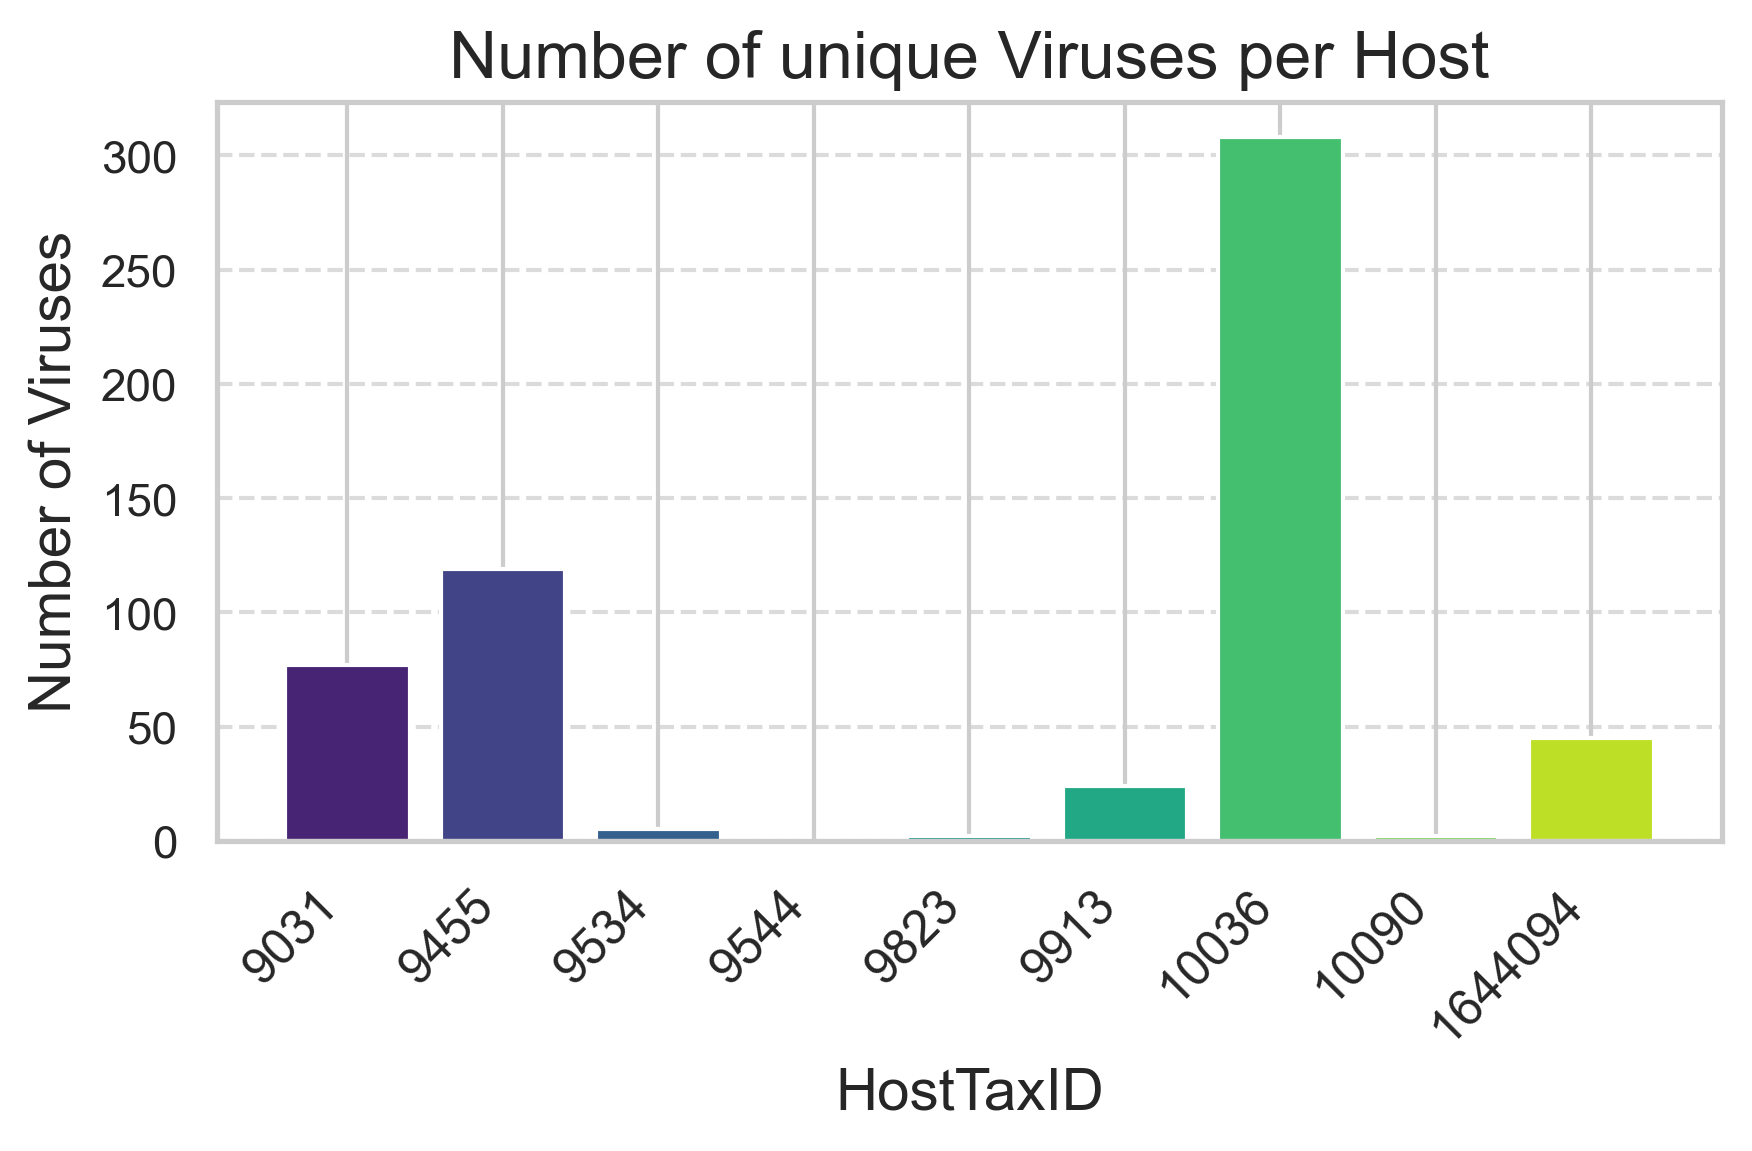

/var/folders/sp/r1gk6h_14l3cf4jh9n22jslh0000gn/T/ipykernel_25978/2223090914.py:69: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(scatter, label='HostTaxID')
/var/folders/sp/r1gk6h_14l3cf4jh9n22jslh0000gn/T/ipykernel_25978/2223090914.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.set_ticklabels([str(host) for host in uniqueHosts])


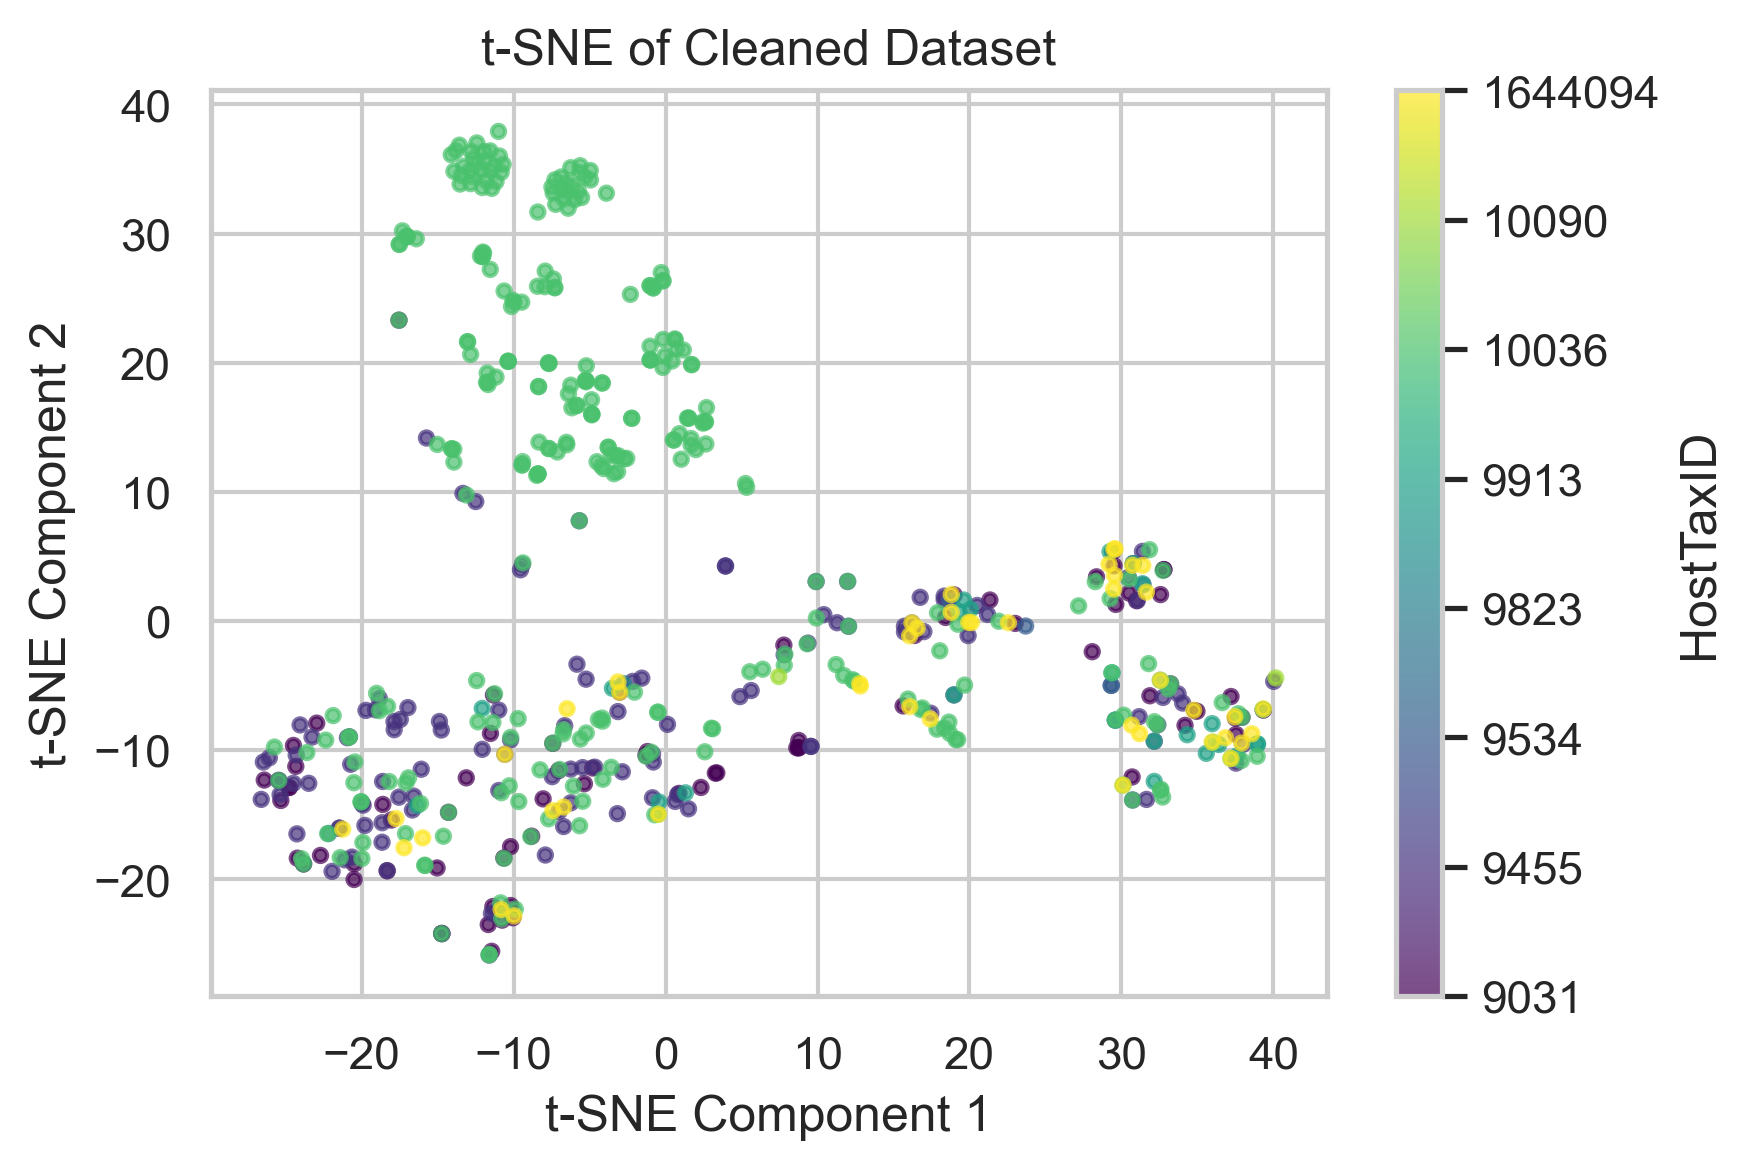

Reconstruction Error (Mean difference between the normalized Original and Reduced Distances): 0.33506819342953886


In [6]:
# Analyze how many viruses overlap between hosts

allHosts = [f.name for f in os.scandir(genomeParentFolder) if f.is_dir()]
filesForHosts = {host: [f.name for f in os.scandir(f"{genomeParentFolder}/{host}") if f.is_file()] for host in allHosts}

# Create a confustion matrix of the host files
confusionMatrix = []
for i, host in enumerate(allHosts):
    confusionMatrix.append([0] * len(allHosts))
    for j, host2 in enumerate(allHosts):
        confusionMatrix[i][j] = len(set(filesForHosts[host]).intersection(set(filesForHosts[host2]))) / min(len(filesForHosts[host]), len(filesForHosts[host2]))

# Plot a Heatmap with Seaborn
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusionMatrix, cmap="YlGnBu", annot=True, fmt=".2f", xticklabels=allHosts, yticklabels=allHosts, cbar_kws={'label': 'Overlap Ratio'}, square=True)
plt.title("Virus Overlap Between Hosts", fontsize=16)
plt.xlabel("Hosts", fontsize=14)
plt.ylabel("Hosts", fontsize=14)
plt.tight_layout()
plt.show()




# Analyze the balance of the clean (no duplicates) dataset

x = list(map(str, featuresPerHost.keys()))
y = [len(featuresPerHost[int(host)]) for host in x]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4), dpi=300)
bars = plt.bar(x, y, color=sns.color_palette("viridis", len(x)))
plt.xlabel("HostTaxID", fontsize=14)
plt.ylabel("Number of Viruses", fontsize=14)
plt.title("Number of unique Viruses per Host", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




# Analyze the structure of the data under the given features (t-SNE)

# Prepare features and labels
y = []
X = []

for host, hostFeatures in featuresPerHost.items():
    for features in hostFeatures:
        y.append(host)
        X.append(features)

y = np.array(y)
X = np.array(X)

uniqueHosts = np.unique(y)
hostToIndex = {host: idx for idx, host in enumerate(uniqueHosts)} 
yColors = np.array([hostToIndex[host] for host in y])

# Perform t-SNE and feature transformation into lower dimension
tsne = TSNE(n_components=2, random_state=randomState, perplexity=30)
tsneX = tsne.fit_transform(X)

# Scatterplot of t-SNE results
plt.figure(figsize=(6, 4), dpi=300)
scatter = plt.scatter(tsneX[:, 0], tsneX[:, 1], c=yColors, cmap='viridis', alpha=0.7, s=10)
colorbar = plt.colorbar(scatter, label='HostTaxID')
colorbar.set_ticklabels([str(host) for host in uniqueHosts])
plt.title('t-SNE of Cleaned Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Calculate reconstruction error (Normalize distances (divide by mean) for fair comparison) and compute mean difference between distance matrices
originalDistances = pairwise_distances(X, metric='euclidean')
reducedDistances = pairwise_distances(tsneX, metric='euclidean')
originalDistances /= originalDistances.mean()
reducedDistances /= reducedDistances.mean()
reconstruction_error = np.mean(abs(originalDistances - reducedDistances))
print(f"Reconstruction Error (Mean difference between the normalized Original and Reduced Distances): {reconstruction_error}")

## 3. Classification

In [7]:
# Choose right classifiers
classifiers = {}
if usedModel == "svm":
    for host in hostsToBuildClassifierFor:
        print("Support Vector Machine selected.")
        classifiers[host] = SVC(kernel = 'rbf', random_state = randomState)
elif usedModel == "elkanoto":
    for host in hostsToBuildClassifierFor:
        print("Elkanoto model selected.")
        classifiers[host] = ElkanotoSVCClassifier(hold_out_ratio=0.1, threshold=0.5, random_state = randomState)
elif usedModel == "kNeightbor":
    for host in hostsToBuildClassifierFor:
        print("kNeighbors selected.")
        classifiers[host] = KNeighborsClassifier(n_neighbors=7)
elif usedModel == "decisionTree":
    for host in hostsToBuildClassifierFor:
        print("Decision Tree selected.")
        classifiers[host] = DecisionTreeClassifier(random_state=randomState)
else:
    print("Model not found.")

# Transform features (X) and host classes (y) into expected format for classifier (exclude hosts that have no values in the training data) and reduce dimesionality if necessary
X = np.concatenate([featuresPerHost[host] for host in hostsToIncludeInTrainingData if featuresPerHost[host].shape[0] > 0])

if reduceFeatureDimensionality:
    X = PCA(n_components=15, random_state=randomState).fit_transform(X)

def getYForHost(h):
    y = []
    for host in hostsToIncludeInTrainingData:
        y += [1 if host == h else 0] * len(featuresPerHost[host])
    return np.array(y)

# Calculate Cross Validation and build model for good performing models
scores = {}
performingModels = {}
specificity = make_scorer(recall_score, pos_label=0)
for host in hostsToBuildClassifierFor:
    print("Running cross validation for host:", host)
    
    # load the training data with right labels
    X = X
    y = getYForHost(host)

    # run k-fold cross validation
    cv = KFold(n_splits=4, shuffle=True, random_state=randomState)
    scores[host] = cross_validate(classifiers[host], X, y, cv=cv, n_jobs=4, scoring={'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall', 'specificity': specificity, 'precision': 'precision', 'f1': 'f1'})

    if scores[host]['test_balanced_accuracy'].all() > 0.7 and scores[host]['test_f1'].all() > 0.7:
        print("Host", host, "can be predicted good enough to build a model for it.")
        performingModels[host] = classifiers[host].fit(X,y)




Support Vector Machine selected.
Running cross validation for host: 10036
Host 10036 can be predicted good enough to build a model for it.


## 4. Evaluation

Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77120871 0.76463964 0.82696078 0.79113924]
Recall: 0.6 [0.56944444 0.58333333 0.67058824 0.58227848]
Specificity: 0.98 [0.97297297 0.94594595 0.98333333 1.        ]
Precision: 0.96 [0.95348837 0.91304348 0.98275862 1.        ]
F1: 0.74 [0.71304348 0.71186441 0.7972028  0.736     ]


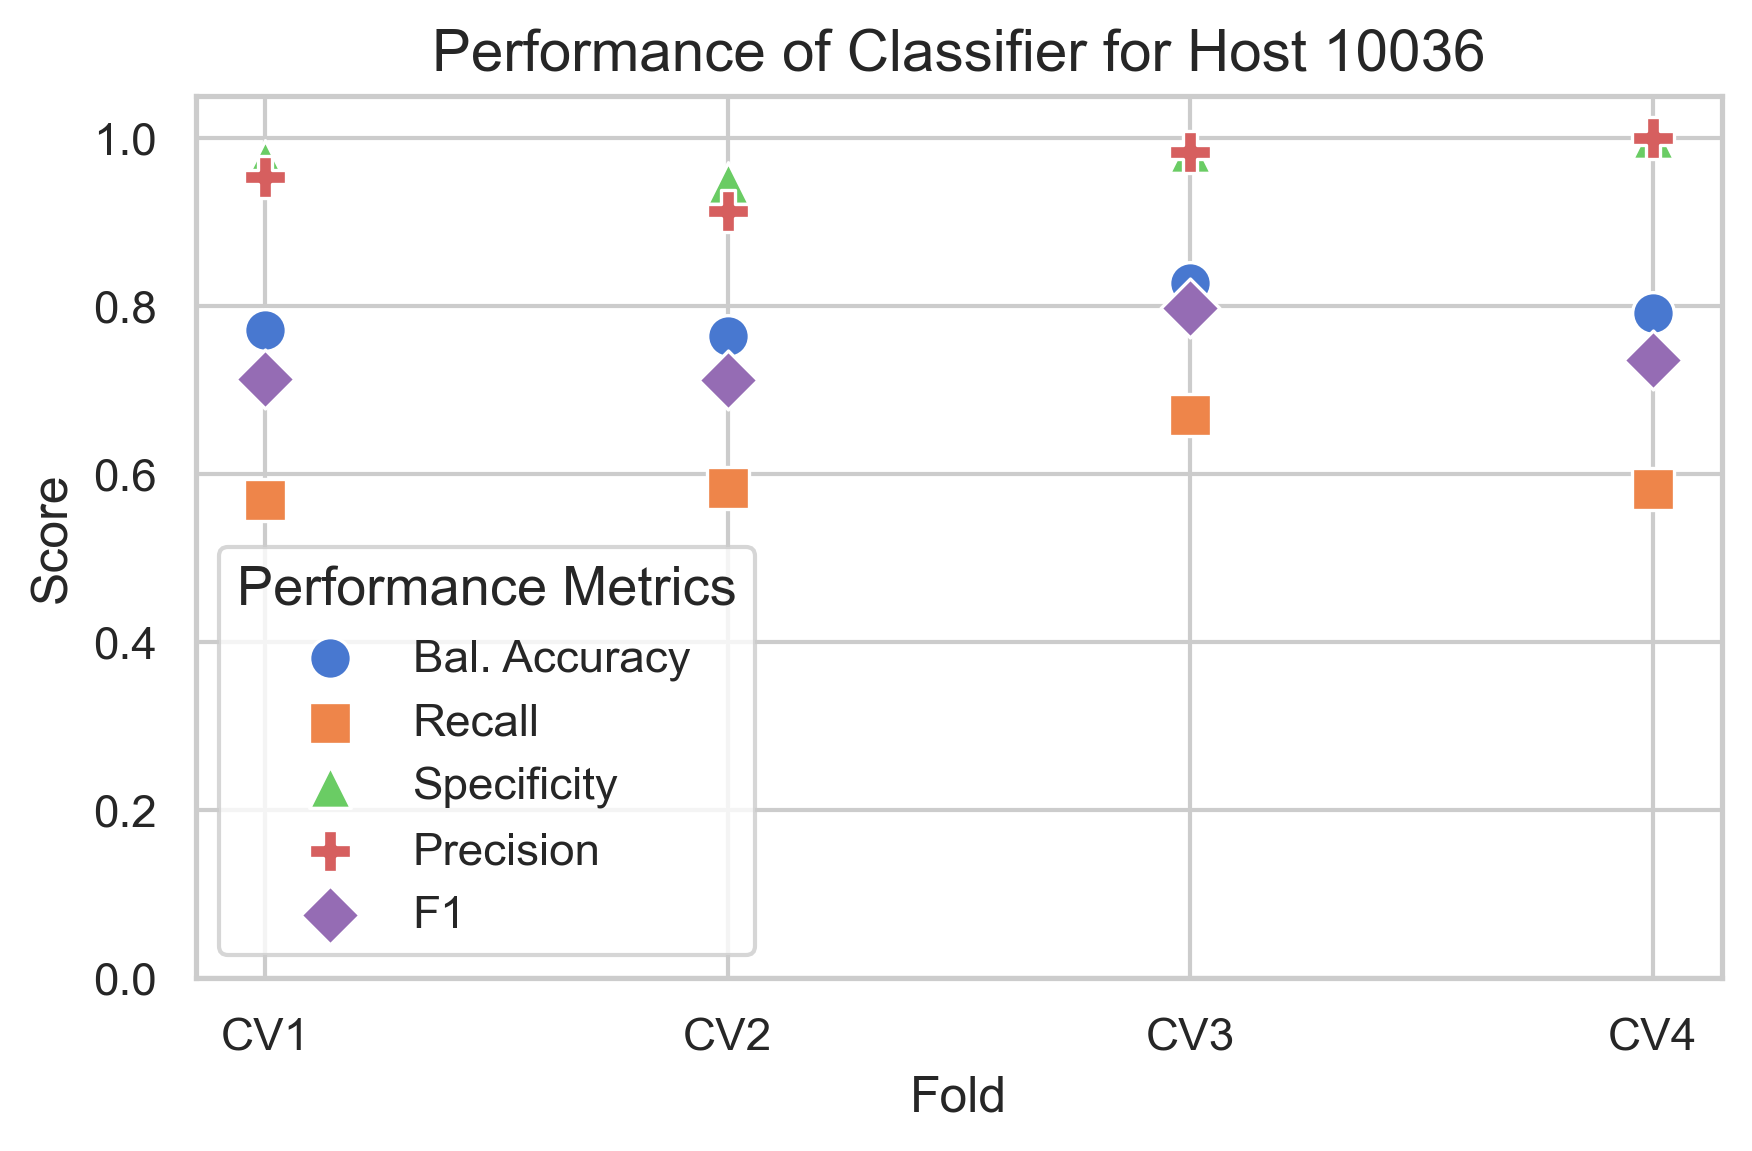

In [8]:

# Plot the classification performance for each host
for host in hostsToBuildClassifierFor:
    print("Results for host:", host)
    print("Feature file:", featureFileToUse)
    print("Balanced accuracy:", round(np.mean(scores[host]['test_balanced_accuracy']), 2), scores[host]['test_balanced_accuracy'])
    print("Recall:", round(np.mean(scores[host]['test_recall']), 2), scores[host]['test_recall'])
    print("Specificity:", round(np.mean(scores[host]['test_specificity']), 2), scores[host]['test_specificity'])
    print("Precision:", round(np.mean(scores[host]['test_precision']), 2), scores[host]['test_precision'])
    print("F1:", round(np.mean(scores[host]['test_f1']), 2), scores[host]['test_f1'])

    modelPerformance = {'Fold': ['CV1', 'CV2', 'CV3', 'CV4'], 'Balanced Accuracy': scores[host]['test_balanced_accuracy'], 'Recall': scores[host]['test_recall'], 'Specificity': scores[host]['test_specificity'], 'Precision': scores[host]['test_precision'], 'F1': scores[host]['test_f1']}
    modelPerformance = pd.DataFrame(modelPerformance)

    # Set setting for plot and plot a line for each evaluation metric
    sns.set_theme(style="whitegrid", palette="muted")
    plt.figure(figsize=(6, 4), dpi=300)
    sns.scatterplot(x='Fold', y='Balanced Accuracy', data=modelPerformance, label='Bal. Accuracy', s=100, marker='o')
    sns.scatterplot(x='Fold', y='Recall', data=modelPerformance, label='Recall', s=100, marker='s')
    sns.scatterplot(x='Fold', y='Specificity', data=modelPerformance, label='Specificity', s=100, marker='^')
    sns.scatterplot(x='Fold', y='Precision', data=modelPerformance, label='Precision', s=100, marker='P')
    sns.scatterplot(x='Fold', y='F1', data=modelPerformance, label='F1', s=100, marker='D')
    plt.ylim(0, 1.05)
    plt.xlabel("Fold", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.title(f"Performance of Classifier for Host {host}", fontsize=14)
    plt.legend(title="Performance Metrics", title_fontsize='13', fontsize='11')
    plt.tight_layout()
    plt.show()


## Choices that we made in the training process 

### Choose valueable datasplits

Ideally we want to train a classifier on balanced input data. As we can see, the most balance predictor uses 10036 as the positive samples, and the others as the negative ones. Another potentially viable combination would be excluding 10036 (bc it has so many viruses) and trying to build a classifier for 9455. This yields the following result:

```
Results for host: 9455
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.59 [0.59137931 0.60186757 0.59437229 0.56684982]
Recall: 0.5 [0.48275862 0.67741935 0.3030303  0.53846154]
Specificity: 0.68 [0.7        0.52631579 0.88571429 0.5952381 ]
Precision: 0.56 [0.53846154 0.53846154 0.71428571 0.4516129 ]
F1: 0.51 [0.50909091 0.6        0.42553191 0.49122807]
```

As we can see the performance is relatively bad, probably in part due to a lack of training data. Including 10036 as negative samples led to a classifier always predicting 0. Therefore, the only viable solution given the data is a predictor for 10036.


### Fine-tuning the features and model

Results from different runs USING SVC WITH RBF-KERNEL with different feature combinations:

```
Results for host: 10036
Feature file: features_kmer_simple-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.78658537 0.77464789 0.82236842]
Recall: 0.58 [0.55696203 0.57317073 0.54929577 0.64473684]
Specificity: 1.0 [0.98507463 1.         1.         1.        ]
Precision: 0.99 [0.97777778 1.         1.         1.        ]
F1: 0.73 [0.70967742 0.72868217 0.70909091 0.784     ]

Results for host: 10036
Feature file: features_kmer_simple-3.csv
Balanced accuracy: 0.78 [0.77101833 0.78658537 0.76056338 0.79996186]
Recall: 0.58 [0.55696203 0.57317073 0.52112676 0.65789474]
Specificity: 0.98 [0.98507463 1.         1.         0.94202899]
Precision: 0.98 [0.97777778 1.         1.         0.92592593]
F1: 0.72 [0.70967742 0.72868217 0.68518519 0.76923077]

Results for host: 10036
Feature file: features_kmer_simple-6.csv
Balanced accuracy: 0.77 [0.78254298 0.77096037 0.75437762 0.77097635]
Recall: 0.59 [0.59493671 0.57317073 0.54929577 0.65789474]
Specificity: 0.95 [0.97014925 0.96875    0.95945946 0.88405797]
Precision: 0.93 [0.95918367 0.95918367 0.92857143 0.86206897]
F1: 0.72 [0.734375   0.71755725 0.69026549 0.74626866]
```

From the above results we can see that the codon frequencies contain the most vital information and the di-codon frequences do not add much to classification performance.

```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.77705793 0.78901789 0.82170099]
Recall: 0.6 [0.55696203 0.58536585 0.5915493  0.65789474]
Specificity: 0.98 [0.98507463 0.96875    0.98648649 0.98550725]
Precision: 0.97 [0.97777778 0.96       0.97674419 0.98039216]
F1: 0.74 [0.70967742 0.72727273 0.73684211 0.78740157]

Results for host: 10036
Feature file: features_kmer-2-3-6.csv
Balanced accuracy: 0.77 [0.76761761 0.74676067 0.78311762 0.78480168]
Recall: 0.63 [0.59493671 0.63414634 0.63380282 0.67105263]
Specificity: 0.91 [0.94029851 0.859375   0.93243243 0.89855072]
Precision: 0.89 [0.92156863 0.85245902 0.9        0.87931034]
F1: 0.74 [0.72307692 0.72727273 0.74380165 0.76119403]
```
We can see that also including the reverse complement does not influence performance substanially, therefore it will be included in further analysis as this potentially allows to feed the algorithm queries where it is not known if it is the reverse complement of the sequence or not.



Including the dinucleotide frequency does not substantually improve recall while reducing specificity, therefore this will not further be done. So the best feature selection therefore seems to be: codon + dicodon frequencies, including the reverse complement of the strand.


Using the ElkanotoSVCClassifier with hold_out_ratio=0.1 and threshold=0.5 we get the following:

```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.7 [0.7029095  0.71646341 0.65816521 0.71157513]
Recall: 0.76 [0.73417722 0.68292683 0.8028169  0.82894737]
Specificity: 0.63 [0.67164179 0.75       0.51351351 0.5942029 ]
Precision: 0.7 [0.725      0.77777778 0.61290323 0.69230769]
F1: 0.73 [0.72955975 0.72727273 0.69512195 0.75449102]
```

Which gives us better recall, but worse specificity.

Using other classifiers based on KNeigbors and a DecisionTree did not yield better results than using the SVC.

Using the SCV with a preceding PCA with 15 components:

```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.78 [0.79000567 0.77877287 0.75494861 0.79729214]
Recall: 0.61 [0.59493671 0.57317073 0.57746479 0.71052632]
Specificity: 0.95 [0.98507463 0.984375   0.93243243 0.88405797]
Precision: 0.93 [0.97916667 0.97916667 0.89130435 0.87096774]
F1: 0.74 [0.74015748 0.72307692 0.7008547  0.7826087 ]
```
We can see that the specificity decreases in comparison to using no PCA, while there is no real improvment in the other metrics.

Trying out other hyperparameters for the SVC, namely different kernels and regularization parameters, did also not yield any improvement.

### Final Model settings

In conclusion, the best performance was reached using a SVC with RBF kernel and default parameters, on the codon and dicodon frequencies including the reverse complement.
```
Results for host: 10036
Feature file: features_kmer-3-6.csv
Balanced accuracy: 0.79 [0.77101833 0.77705793 0.78901789 0.82170099]
Recall: 0.6 [0.55696203 0.58536585 0.5915493  0.65789474]
Specificity: 0.98 [0.98507463 0.96875    0.98648649 0.98550725]
Precision: 0.97 [0.97777778 0.96       0.97674419 0.98039216]
F1: 0.74 [0.70967742 0.72727273 0.73684211 0.78740157]
```


## 5. Query Prediction

In [9]:
# Read query files
queryFiles = [f for f in os.scandir(queryParentFolder) if f.is_file() and f.name.endswith((".fna" or ".fasta"))]
queryFeatures = {}

# Predict queries with eaxh valueable host model
for queryFile in queryFiles:
    queryRecord = SeqIO.read(queryFile, "fasta")
    features = dataPreprocessor.extractFeaturesFromGenome(str(queryRecord.seq), queryFeatureSet)
    featuresFlat = []
    for key, value in features.items():
      if isinstance(value, list):  
          if all(isinstance(v, float) for v in value):  # Make sure List contains just floats
              featuresFlat.extend(value)
          else:
              raise ValueError(f"Unexpected type in list for key '{key}': {value}")
      elif isinstance(value, float):
          featuresFlat.append(value)
      else:
          raise ValueError(f"Unexpected value type for key '{key}': {value}")
    queryFeatures[queryRecord.id] = featuresFlat


queryFeaturesDataframe = pd.DataFrame(queryFeatures).transpose()

for virus, features in queryFeatures.items():
    predictions = {}
    for host, classifier in performingModels.items():
        hostPredictions = classifier.predict([features])
        predictions[host] = hostPredictions


    print("Predictions for virus", virus, ":")
    for host, preds in predictions.items():
        print(f"Prediction for host {host}: {preds}")
    print("\n")

Predictions for virus AF095689.1 :
Prediction for host 10036: [0]


Predictions for virus BK000415.1 :
Prediction for host 10036: [0]


Predictions for virus KT030400.1 :
Prediction for host 10036: [1]


Predictions for virus KP940128.1 :
Prediction for host 10036: [1]


Predictions for virus X05817.1 :
Prediction for host 10036: [0]


Predictions for virus OP868847.1 :
Prediction for host 10036: [0]


